# <center> Tesla Energy Time Series Data Challenge </center> #

><b> 💁‍ Author: Mei Mei 

><b> 📧 Email: vickymei713@gmail.com
    
><b> 📌 GitHub Link: https://github.com/vickymei/tesla_energy_project

## Summary 

This project focuses on solving the problem of identifying malfunctioning Energy Production Sites by 

1. Built a <b>ETL pipeline</b> to collect signal data through 2 Energy Realtime Data API Endpoints
2. Collected <b>29 hours</b> historical data 
3. Provided a <b>Plotly Dash</b> dashboard for visualizing data from <b>42</b> sites
4. Proposed solutions for more in-depth <b>Anomaly Detection</b> 

This Notebook will explain this project in the following order: 

<b>Part 1. ETL Pipeline Building</b> 

<b>Part 2. Data Processing & Plotly Visualization</b>

<b>Part 3. Analysis and Insights on Malfunctioning Sites</b>

<b>Part 4. More Anomaly Detection Thoughts</b>

## Part 1. ETL Pipeline Building 

This section aims at building data pipeline and collecting signal data using pipelinel.  
1. There will be one json file generated every minute. After running the script for roughly 29 hours, there are <b>29 hours * 60 = 1740 </b>files in <b>data/ directory</b>
2. Json files are named by timestamp of generation time
3. Try Except is utilized for possible api call failure

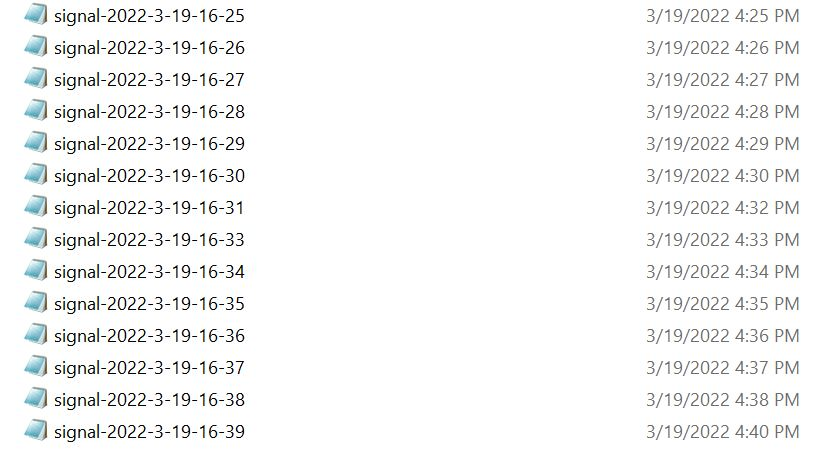

```python
def get_sites_from_api():
    """Return list of all existing sites."""
    load_dotenv()
    json_data = requests.get(
        "https://te-data-test.herokuapp.com/api/sites?token="+os.environ.get("api-token")).json()
    sites = json_data["sites"]
    return sites
def get_signals_from_api(site):
    """Return site signal data."""
    load_dotenv()
    json_data = requests.get(
        "https://te-data-test.herokuapp.com/api/signals?token="+os.environ.get("api-token")+f"&site={site}").json()
    return json_data
```

```python
def main():
    """Write signal data to local file system in json format every minute. """
    sites = get_sites_from_api()
    site_data = []
    timestamp_now = datetime.now()
    timestamp_file_name = f"signal-{timestamp_now.year}-{timestamp_now.month}-{timestamp_now.day}-{timestamp_now.hour}-{timestamp_now.minute}-{timestamp_now.second}.json"
    for site in sites:
        try:
            site_data.append(get_signals_from_api(site))
        except:
            error_data = {
                'signals': {'SITE_SM_batteryInstPower': None, 'SITE_SM_siteInstPower': None, 'SITE_SM_solarInstPower': None},
                'site': site, 'timestamp': None}
            site_data.append(error_data)

        with open(f"data/{timestamp_file_name}", 'w') as f:
            json.dump(site_data, f)
    return 'success'
```

<b>Note:</b> 
By setting sleeping time and calling api at a relatively low frequency (per minute), I didn't notice data loss due to API issues during data collection. 

## Part 2. Data Processing & Plotly Visualization 

### Data Processing 

In [1]:
import json
import pandas as pd
import os
import missingno as msno
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
%matplotlib inline
pd.set_option('display.max_rows', 20)

In [2]:
# Read all json files and print statements about number of records
path_to_json = 'data/'
json_files = [f'data/{pos_json}' for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(f"There are {len(json_files)} json files in total.")
js = []
for fn in json_files:
    with open(fn, 'r') as f:
        js = js + json.load(f)
print(f"There are {len(js)} signal from 42 sites in total.")

There are 1667 json files in total.
There are 70014 signal from 42 sites in total.


In [3]:
# Transform dataframe for later analysis 
df = pd.DataFrame(js)
df.head(5)

,signals,site,timestamp
0,{'SITE_SM_batteryInstPower': -3414.33333333333...,134a3fa6,"Sat, 19 Mar 2022 20:57:43 GMT"
1,"{'SITE_SM_batteryInstPower': 0.0, 'SITE_SM_sit...",8d9fed87,"Sat, 19 Mar 2022 20:57:43 GMT"
2,"{'SITE_SM_batteryInstPower': 7.16666666666697,...",5688ed10,"Sat, 19 Mar 2022 20:57:43 GMT"
3,{},2b33a48d,"Sat, 19 Mar 2022 20:57:44 GMT"
4,"{'SITE_SM_batteryInstPower': 4.66666666666697,...",07333ad0,"Sat, 19 Mar 2022 20:57:44 GMT"


In [4]:
# Transform dataframe for later analysis 
df_main = pd.concat([df.drop(['signals'], axis=1), df['signals'].apply(pd.Series)], axis=1)
df_main = df_main[['site', 'timestamp', 'SITE_SM_solarInstPower']]
df_main['timestamp'] = pd.to_datetime(df_main['timestamp'])
df_main.head(5)

,site,timestamp,SITE_SM_solarInstPower
0,134a3fa6,2022-03-19 20:57:43,3403.336739
1,8d9fed87,2022-03-19 20:57:43,4344.266667
2,5688ed10,2022-03-19 20:57:43,437.573161
3,2b33a48d,2022-03-19 20:57:44,NaN
4,07333ad0,2022-03-19 20:57:44,448.225990


In [5]:
# Put all sites' name into a list 
sites =['134a3fa6', '8d9fed87', '5688ed10', '2b33a48d', '07333ad0', '38c8ae33',
         'adc42b19', 'e9ba8cec', 'e12c2148', '4b78aae6', 'e724ca65', '135433c1',
         '90606897', '02ebf5c7', 'c8eb2d3d', '2b98cbdd', '39146e59', '55af2f9b',
         '28731623', '3193e230', 'e6bcf7cf', '7da0acb7', 'c18b6195', '20abb173',
         'f34b386a', 'f7f9ac09', '5fc96249', '82c74b9e', 'b255f7ad', '61bff705',
         '619fd2b9', '260f359a', '4faff963', '499a251d', 'dfc6fdf5', '64e1616f',
         '93c8a2c1', 'eec02ec5', '90791ae9', '49b6c0dd', 'd0926969', '7435e9d3']

In [6]:
# Ignore the minor 1 or 2 sec difference for all sites signal from one api call, using timestamp of site 134a3fa6
df_timestamp = df_main[df_main['site']=="134a3fa6"].reset_index(drop=True)[['timestamp']]

# We are investigating solar production signals, so variable 'SITE_SM_solarInstPower' is the target variable  
for site in sites:
    df_site = df_main[df_main['site']==site].reset_index(drop=True)
    df_timestamp.loc[:, site] = df_site['SITE_SM_solarInstPower'].tolist()

# timestamp dataframe is saved in csv format for plotly dashboard building    
df_timestamp.to_csv('timestamp.csv')
df_timestamp.head(5)

,timestamp,134a3fa6,8d9fed87,5688ed10,2b33a48d,07333ad0,38c8ae33,adc42b19,e9ba8cec,e12c2148,...,4faff963,499a251d,dfc6fdf5,64e1616f,93c8a2c1,eec02ec5,90791ae9,49b6c0dd,d0926969,7435e9d3
0,2022-03-19 20:57:43,3403.336739,4344.266667,437.573161,NaN,448.225990,6110.992692,5523.014772,5113.606738,NaN,...,4215.170528,4383.612740,3282.888245,1223.836690,907.618911,2578.168376,NaN,-4985.000000,4004.176790,4087.807043
1,2022-03-19 20:58:51,3404.770422,4340.300000,445.777338,NaN,457.889992,6091.835352,5507.404686,1897.581341,NaN,...,4199.216077,4382.053394,2765.066264,1217.529663,879.811578,2484.924929,NaN,-4968.333333,4070.669789,4081.189115
2,2022-03-19 21:00:00,3418.550049,4336.000000,411.289993,NaN,401.613658,6082.840914,5565.476181,1279.977689,NaN,...,4228.840137,4366.201831,4356.591626,1219.689964,919.166264,2459.310309,NaN,-4951.466667,4013.669645,4063.321370
3,2022-03-19 21:01:08,3422.228621,4335.600000,409.786501,NaN,411.689494,6062.092505,5562.049523,1906.843384,NaN,...,4227.100159,4351.237549,2972.059998,1228.125000,888.223281,2393.627360,NaN,-4945.866667,4025.235328,4033.711096
4,2022-03-19 21:10:16,3443.948014,4295.333333,360.828673,NaN,363.633322,5982.764388,5504.620649,5441.281632,NaN,...,4223.939290,NaN,3839.650232,1240.621342,608.454421,1730.303684,NaN,-4912.933333,3877.953520,4053.904004


### Plotly Visualization 

The screenshot below is a simple plotly dashboard to visualize all sites signals. You could <b>select</b> different site code to see data coming from any of the 42 sites. 

In order to run the app on your local machine, you need to run `python viz.py` in your terminal and visit http://127.0.0.1:8050/ in your web browser.

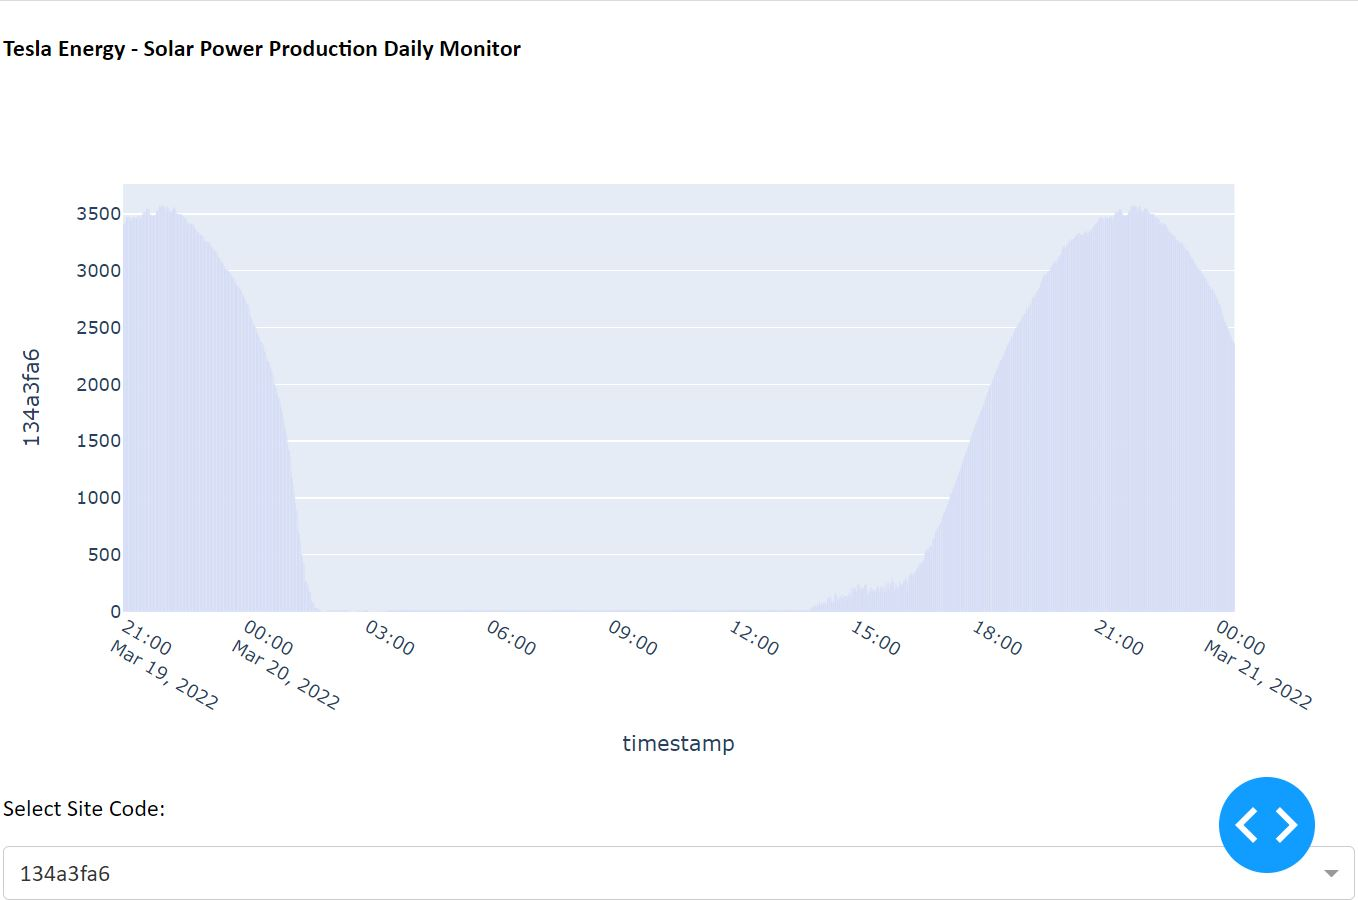

>The Code snippet below creates the simple dashboard above. 

```python
app = dash.Dash(__name__)

sites = ['134a3fa6', '8d9fed87', '5688ed10', '2b33a48d', '07333ad0', '38c8ae33',
         'adc42b19', 'e9ba8cec', 'e12c2148', '4b78aae6', 'e724ca65', '135433c1',
         '90606897', '02ebf5c7', 'c8eb2d3d', '2b98cbdd', '39146e59', '55af2f9b',
         '28731623', '3193e230', 'e6bcf7cf', '7da0acb7', 'c18b6195', '20abb173',
         'f34b386a', 'f7f9ac09', '5fc96249', '82c74b9e', 'b255f7ad', '61bff705',
         '619fd2b9', '260f359a', '4faff963', '499a251d', 'dfc6fdf5', '64e1616f',
         '93c8a2c1', 'eec02ec5', '90791ae9', '49b6c0dd', 'd0926969', '7435e9d3']

app.layout = dash.html.Div([
    dash.html.H4('Tesla Energy - Solar Power Production Daily Monitor'),
    dash.dcc.Graph(id="time-series-chart"),
    dash.html.P("Select Site Code: "),
    dash.dcc.Dropdown(
        id="ticker",
        options=sites,
        value="134a3fa6",
        clearable=False,
    ),
])


@app.callback(
    dash.Output("time-series-chart", "figure"),
    dash.Input("ticker", "value"))
def display_time_series(ticker):
    df1 = pd.read_csv('timestamp.csv')
    fig = px.bar(df1, x='timestamp', y=ticker)
    return fig
```

## Part 3. Analysis and Insights on Malfunctioning Sites

### Sites return No Signals (Missing Values)

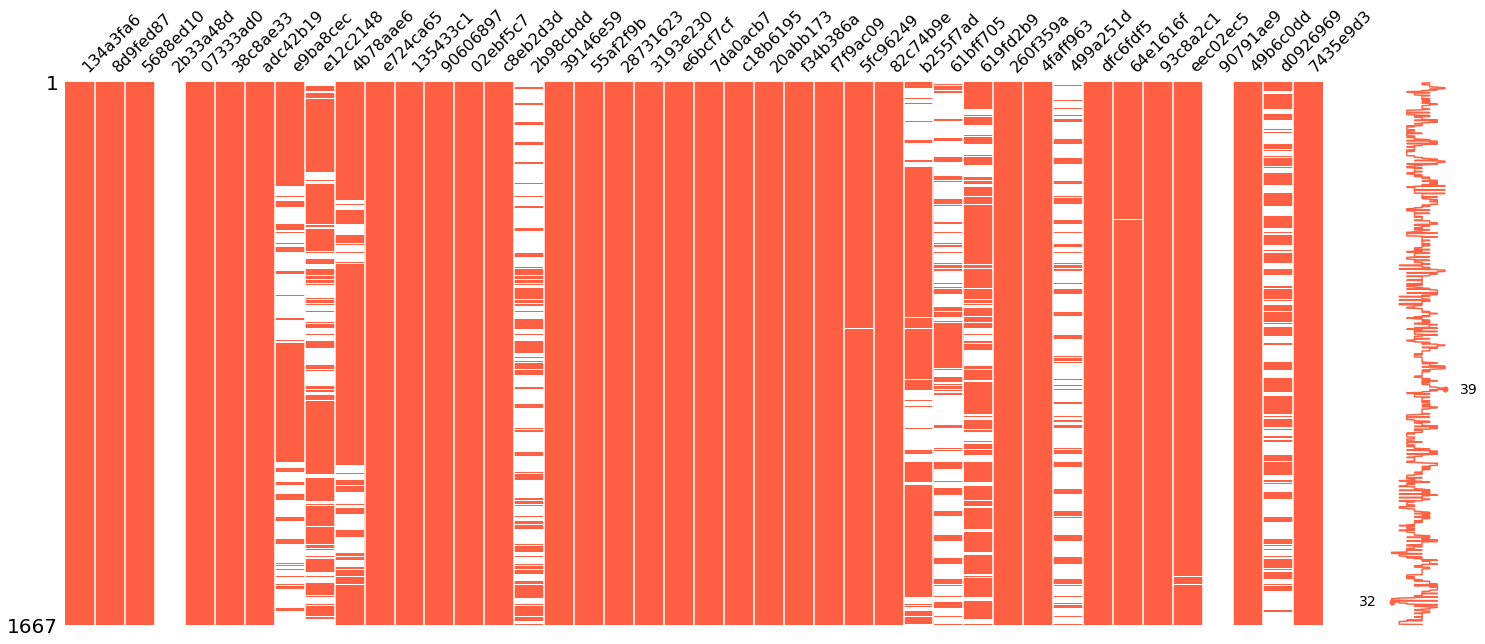

In [7]:
df_missing = df_timestamp.drop('timestamp', axis=1)
msno.matrix(df_missing, color=(1, 0.38, 0.27))

### Sites return negative signals (Solar Production should always be positive)

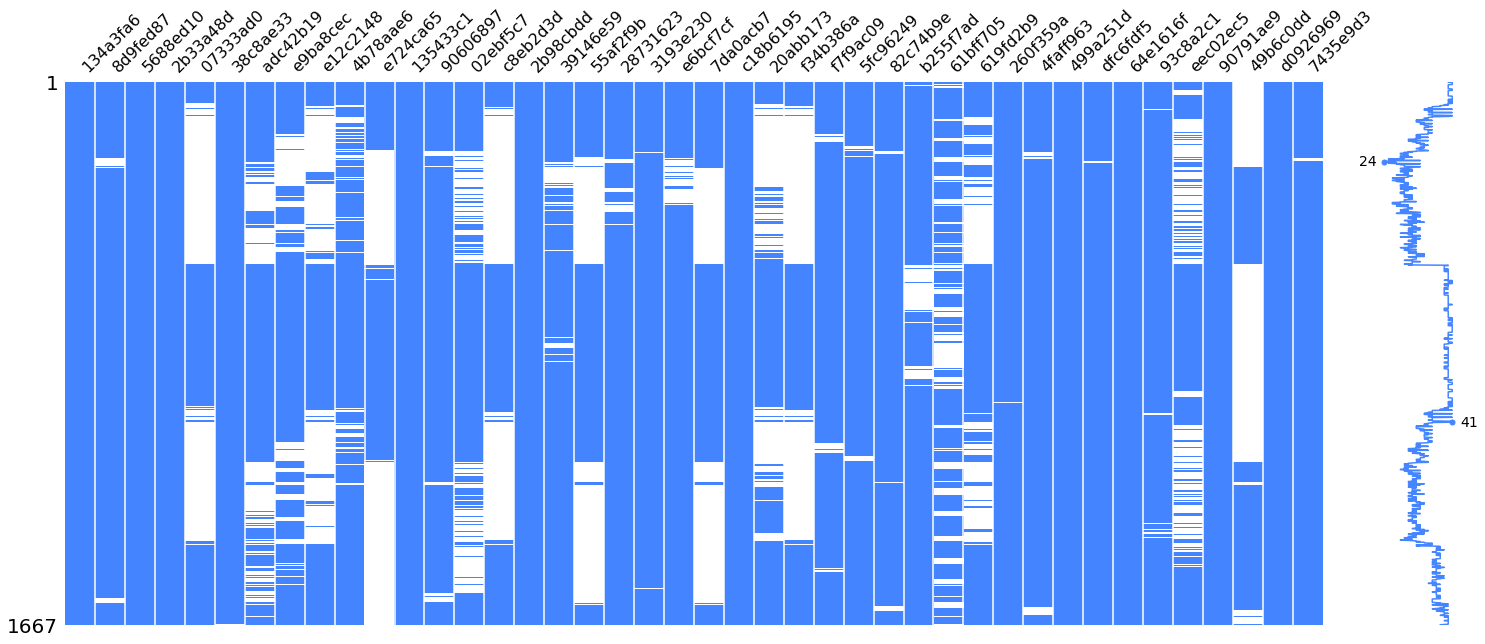

In [8]:
df_negative = df_missing.fillna(0)
df_negative[df_negative < 0] = np.nan
msno.matrix(df_negative, color=(0.27, 0.52, 1.0))

### Insights driven from Plotly Dashboard  And  Heatmaps of Null value & Negative value 

-  Well performing Sites with expected data distribution - Observed through Dashboard 

    - For solar power production, averge active time is <b>12 hours</b> a day and peak time shows around <b>noon</b> 
    - Some well performing sites have very small negative value returned at night  
 
-  Overall well performing Sites with expected data distribution but some anomalies - Observed through Dashboard 


-  Malfunctioning sites with large amount of missing values - Observed Through heatmap
 
 
-  Malfunctioning sites with large amount of negative values - Observed Through heatmap


-  Malfunctioning sites with expected distribution but negative values(mistaken value sites) - Observed through Dashboard 


-  Malfunctioning sites with expected distribution but missing values internmittenly - Observed through Dashboard 


-  Malfunctioning sites with wrong shape and very low energy production - Observed through Dashboard 



#### 1. Well performing Sites with expected data distribution
*Note: some sites return very small negative values at night.*

>134a3fa6 8d9fed87 38c8ae33 adc42b19  90606897   02ebf5c7   55af2f9b  28731623  3193e230   e6bcf7cf   82c74b9e   7435e9d3

>See example below - (GMT time zone)

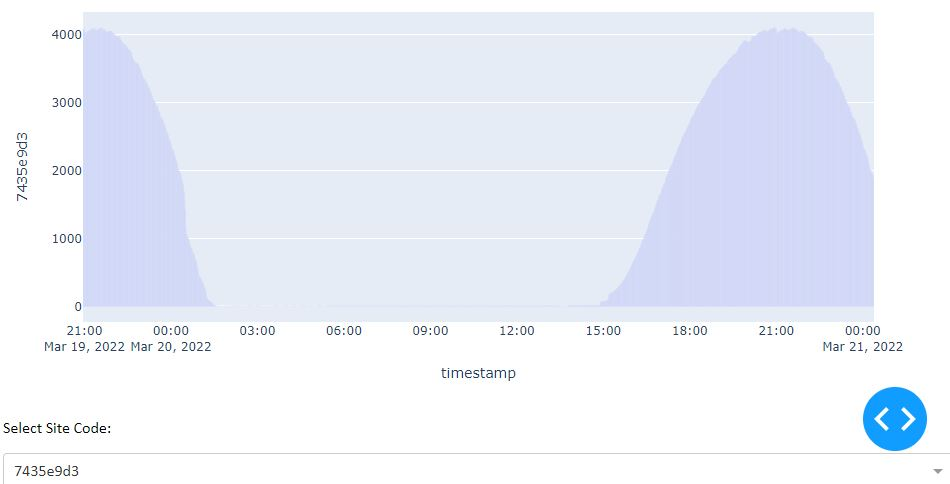

#### 2. Cloudy(?) Sites with expected data distribution
*Note:These sites follow expected trends but have some anomalies during the day*
> 5688ed10 07333ad0, 4b78aae6 135433c1   c8eb2d3d   7da0acb7  c18b6195  20abb173  f34b386a f7f9ac09  5fc96249 260f359a   4faff963 dfc6fdf5  64e1616f  93c8a2c1  eec02ec5  

>See example below

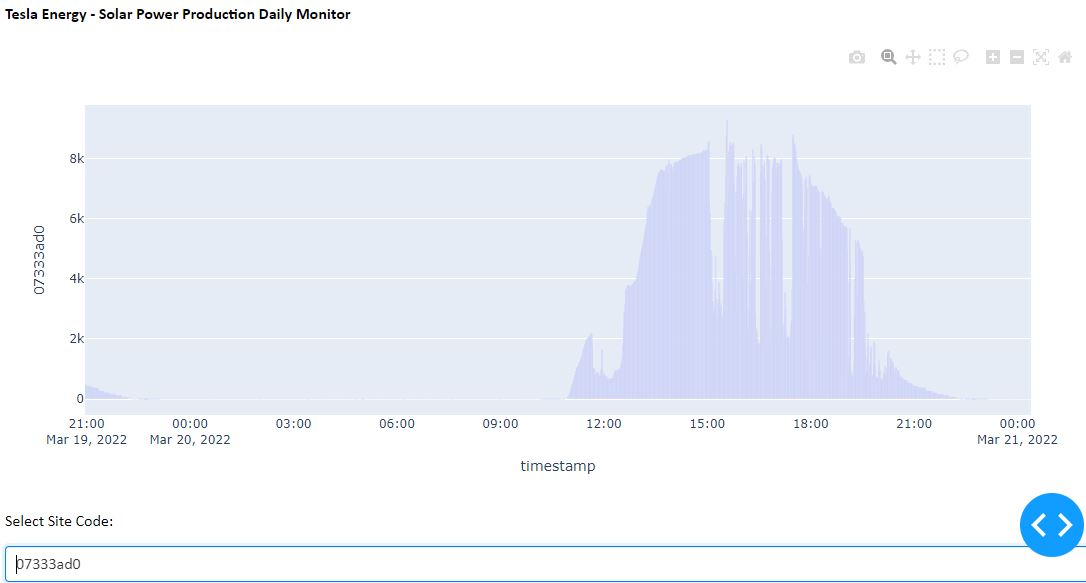

#### 3. Malfunctioning sites with large amount of missing values - Heatmap

> <b>2b33a48d</b>(Empty)  <b>90791ae9</b>(Empty)  e9ba8cec  e12c2148  4b78aae6  2b98cbdd  b255f7ad  61bff705   619fd2b9   499a251d  d0926969  

#### 4. Malfunctioning sites with large amount of negative values - Heatmap
*Note: some are very small negative values*

> 8d9fed87 07333ad0   adc42b19   e9ba8cec  e12c2148  4b78aae6   e724ca65   90606897  02ebf5c7  c8eb2d3d   39146e59 
55af2f9b   28731623   e6bcf7cf   7da0acb7  20abb173   f34b386a  f7f9ac09  5fc96249 82c74b9e b255f7ad 61bff705 619fd2b9 4faff963
eec02ec5 49b6c0dd


#### 5. Malfunctioning sites with expected distribution but negative values
> 61bff705  49b6c0dd 

> See example below

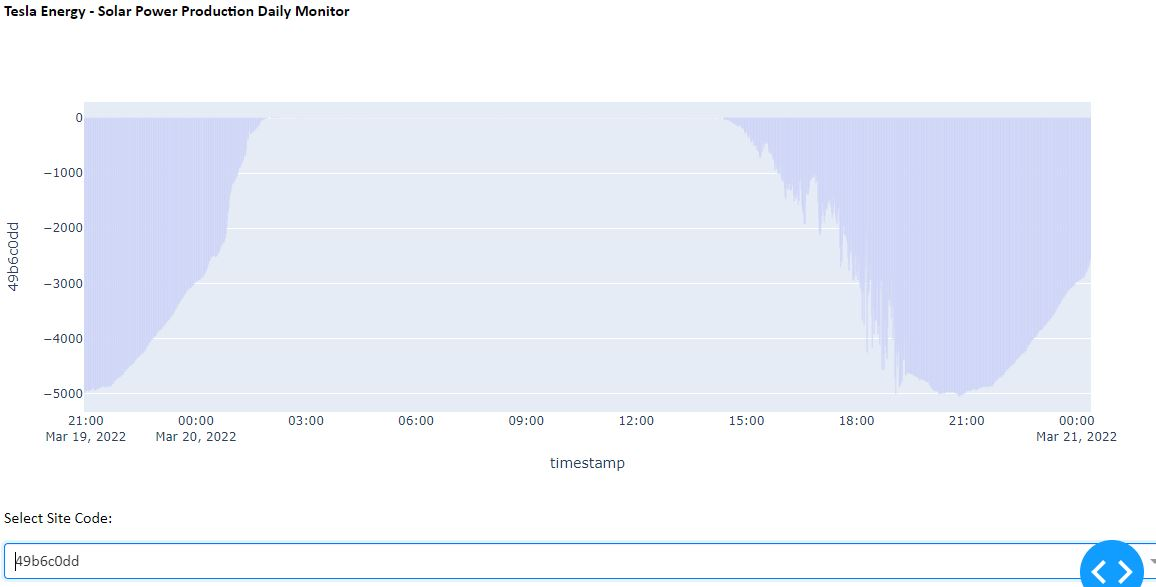

#### 6. Malfunctioning sites with expected distribution but missing data intermittently 
> e9ba8cec  e12c2148 b255f7ad  619fd2b9 499a251d  d0926969

> See example below 
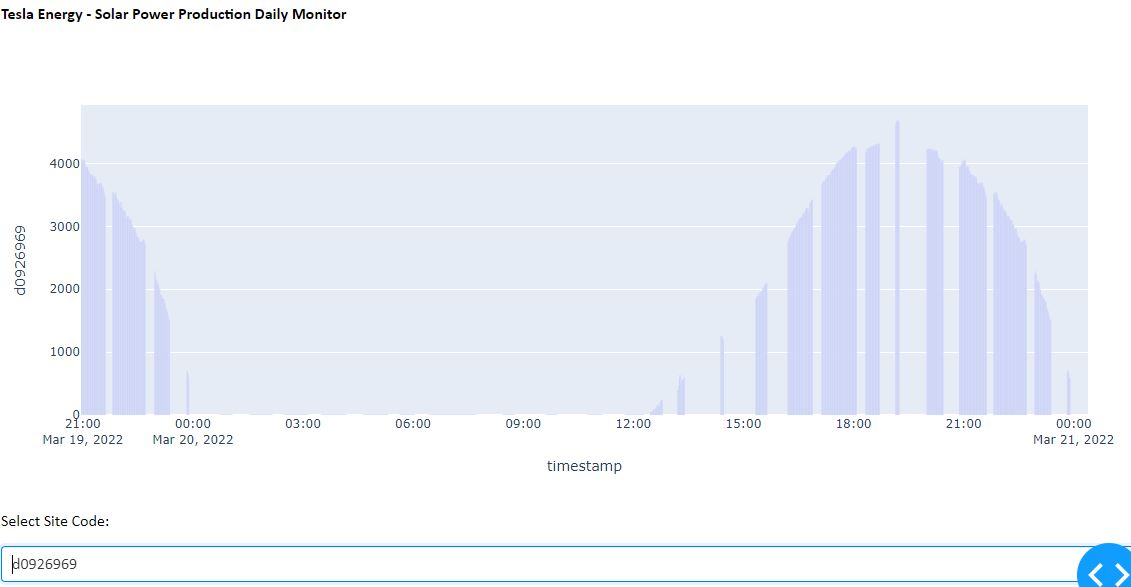

#### 7. Malfunctioning sites with wrong data distribution and low energy producing
> 2b98cbdd  39146e59  

> See example below 
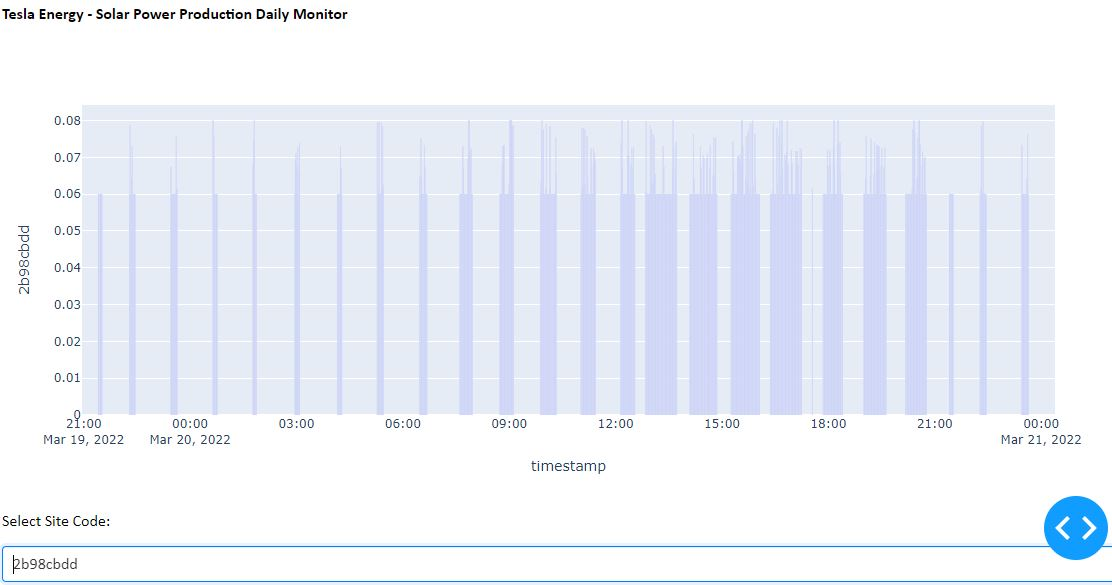

## Part 4. More Anomaly Detection Thoughts
<b>Note</b>: Solar Energy Production has major data fluctuation and drift during a day by nature and it depends on geolocation, season and weather. Much more data is needed in order to build a predictive model. However defining upper and lower bounds using baseline approach is doable for more detailed anomaly detection.  
Reference: https://aditya-bhattacharya.net/2020/07/20/sales-and-demand-forecast-analysis/3/

### Statistical Profiling Approach (Baseline Approach)
 
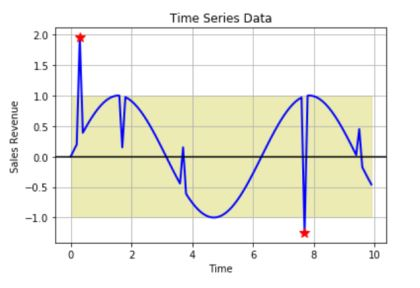
  <b>pros:</b> 
  - This approach provides a more controlled and explainable outcome 
  - There is no fine tuning available 
  
  
 <b>cons:</b> 
  - It's not good at detecting local outlier 
  
### Predictive Confidence Level Approach   

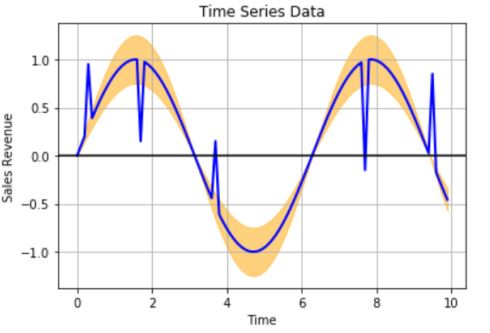
  <b>pros:</b> 
   - There are many effective time series modeling algorithms like ARIMA, SARIMA and regression based machine learning algorithms
   - It's good at finding local outlier   
  
  
  <b>cons:</b>
   - A lot of training data is needed to train an efficient model, otherwise we couldn't trust its accuracy 